# Optoelectronic Systems Theory Assignment

1. For a cylindrical diffraction-limited optical system (Fig. 1), on which a plane monochromatic wave with length $\lambda$ and amplitude $A=1$ falls, find:

    1. A coherent transfer function $\tilde{h}(\nu_x)$ and plot its graph
    2. An optical transfer function $\tilde{H}_N^{OS}(\nu_x)$ and plot its graph

2. Find a polychromatic transfer function $\tilde{H}^{PC}(\nu_x)$ for the radiation of a corresponding blackbody with temperature $T$, if the image is formed in the rear focal plane, and the spectral sensitivity of the radiation receiver is approximated by a Gaussian distribution with a mathematical expectation of 600 nm and a standard deviation of 100 nm. The pupil function $P(\xi)$ is shown in Figure 2.

3. Find the time-frequency spectrum of the radiation flux $\tilde{\Phi}_t(\nu_t)$ and the magnitude of the radiation flux $\Phi_t(t)$ in the image analysis plane of the optical system at the output of the modulator of the image analyzer during its linear scanning (Fig. 3) and plot their graphs. The optical system is a lens with a normalized scattering function $H_N^{OS}(x', y')=\delta(x', y')$, the source of radiation is an object in the form of a rectangle with a constant energy brightness $L_0$, the study of which obeys Lambert's law. The modulator of the image analyzer is a lattice with a cosine distribution of the transmission coefficient along the x axis.

In [33]:
import numpy as np
from scipy import signal, constants
import matplotlib.pyplot as plt

## Initial data

In [141]:
wavelength = 0.8e-3 # mm
focus = 90 # mm
T = 5000 # K
mu = 0.6e-3 # mm
sigma = 0.1e-3 # mm

def triangle(x):
    return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)

def rect(x):
    return np.where(np.abs(x) <= 0.5, 1, 0)

def pupil(x):
    return triangle((x - 3) / 3) * rect((x - 1.5) / 3)

## Pupil function

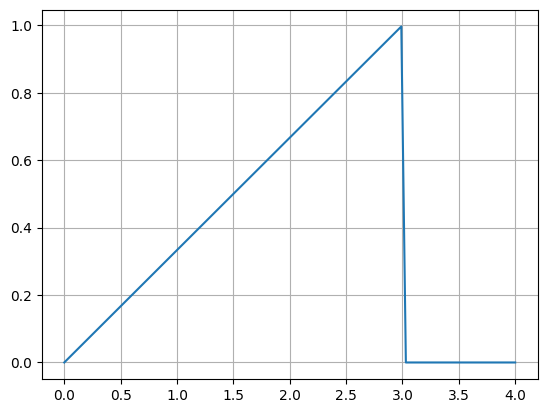

In [143]:
x = np.linspace(0, 4, 100)

plt.figure()
plt.plot(x, pupil(x))
plt.grid()
plt.show()

In [144]:
pupil_diameter = 3
max_frequency = pupil_diameter / (wavelength * focus)
print('Max frequency = {:.3f} [1/mm]'.format(max_frequency))

Max frequency = 41.667 [1/mm]


In [145]:
def transfer_function(pupil_func, frequency, wavelength, focus):
    return signal.convolve(pupil_func(-frequency * wavelength * focus), pupil_func(frequency * wavelength * focus), 'same')

def transfer_function_n(pupil_func, frequency, wavelength, focus):
    result = transfer_function(pupil_func, frequency, wavelength, focus)
    return result / np.max(result)

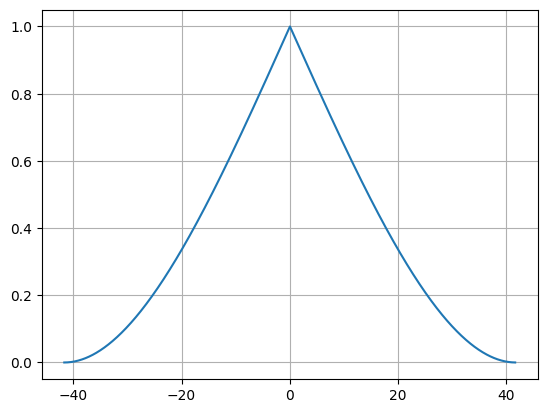

In [148]:
freq = np.linspace(-max_frequency, max_frequency, 1000)
H = transfer_function_n(pupil, freq, wavelength, focus)

plt.figure()
plt.plot(freq, H)
plt.grid()
plt.show()

In [149]:
wien = constants.value('Wien wavelength displacement law constant')
wavelength_peak = wien * 1e3 / T
print(wavelength_peak)

0.000579554391


In [150]:
def sensitivity_n(wavelength):
    return np.exp(-(wavelength - mu) ** 2 / (2 * sigma ** 2))

def luminance(wavelength):
    c = constants.c * 1e3 # mm
    numerator = 4 * (c ** 2) * constants.hbar
    exp = np.exp((2 * np.pi * constants.hbar * c) / (wavelength * constants.k * T))
    denominator = (wavelength ** 5) * (exp - 1)

    return numerator / denominator

def luminance_n(wavelength):
    return luminance(wavelength) / luminance(wavelength_peak)

C:\Users\Maksim Vinogradov\AppData\Local\Temp\ipykernel_20280\2852790975.py:7: RuntimeWarning: divide by zero encountered in divide
  exp = np.exp((2 * np.pi * constants.hbar * c) / (wavelength * constants.k * T))
C:\Users\Maksim Vinogradov\AppData\Local\Temp\ipykernel_20280\2852790975.py:7: RuntimeWarning: overflow encountered in exp
  exp = np.exp((2 * np.pi * constants.hbar * c) / (wavelength * constants.k * T))
C:\Users\Maksim Vinogradov\AppData\Local\Temp\ipykernel_20280\2852790975.py:8: RuntimeWarning: invalid value encountered in multiply
  denominator = (wavelength ** 5) * (exp - 1)


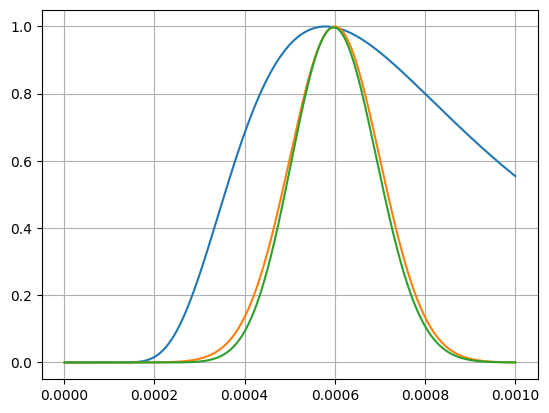

In [151]:
wv = np.linspace(0, 1e-3, 1000)

S = sensitivity_n(wv)
L = luminance_n(wv)

plt.figure()
plt.plot(wv, L)
plt.plot(wv, S)
plt.plot(wv, S * L)
plt.grid()
plt.show()

In [152]:
spectrum = S * L
start_index = np.argmax(spectrum >= 0.01)
end_index = len(spectrum) - np.argmax(spectrum[::-1] >= 0.01)

start_wavelength = wv[start_index]
end_wavelength = wv[end_index]

print(start_index, end_index)
print(start_wavelength, end_wavelength)

330 890
0.0003303303303303303 0.0008908908908908909


In [155]:
def transfer_function_polychromatic(pupil_func, sensitivity_func, luminance_func, frequency, start_wavelength, end_wavelength, focus):
    delta_wavelength = 1e-5
    wavelength_range = np.arange(start_wavelength, end_wavelength, delta_wavelength)
    
    numerator = np.sum([transfer_function_n(pupil_func, frequency, wv, focus) * sensitivity_func(wv) * luminance_func(wv) * delta_wavelength for wv in wavelength_range], 0)
    denominator = np.sum([sensitivity_func(wv) * luminance_func(wv) * delta_wavelength for wv in wavelength_range])

    return numerator / denominator

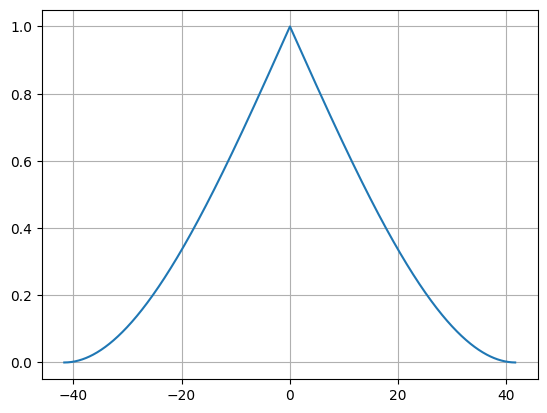

In [156]:
H_pc = transfer_function_polychromatic(pupil, sensitivity_n, luminance_n, freq, start_wavelength, end_wavelength, focus)

plt.figure()
plt.plot(freq, H_pc)
plt.grid()
plt.show()

In [159]:
b = 6 # mm
beta = 0.5
period_x = 2.5 # mm
vel_x = 90 # mm/s
c = 1 # mm
sigma_aperture = 7 # deg
tau = 1
luminance_0 = 0.7e-6 # W / (mm^2 * srad)

In [173]:
flux_0 = 0.5 * np.pi * tau * np.sin(sigma_aperture * (np.pi / 180)) ** 2 * luminance_0 * 2 * b * 2 * c
flux_0

3.9193865806850914e-07

In [174]:
def sinc(x):
    return np.where(x == 0, 1, np.sin(x) / x)

def flux(t):
    return flux_0 + flux_0 * sinc(2 * np.pi * b * beta / period_x) * np.cos(2 * np.pi * vel_x / period_x * t)

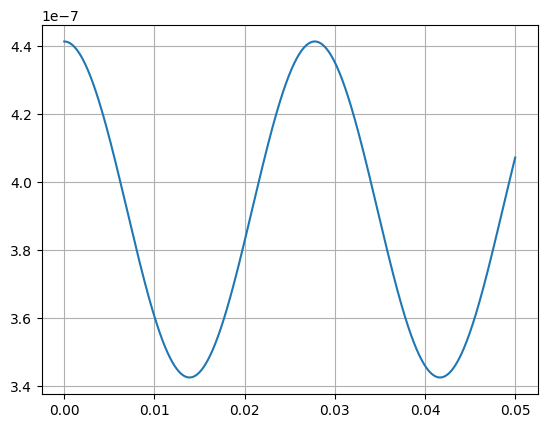

In [176]:
t = np.linspace(0, 0.05, 1000)

plt.figure()
plt.plot(t, flux(t))
plt.grid()
plt.show()